In [5]:


import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cpu
Is CUDA enabled? False


Należy dla jedno i dwuwarstwowej sieci neuronowej porównać wyniki i krzywe 
uczenia w zależności od:
• Liczby neuronów w warstwie ukrytej
• Rozmiaru batcha
• Liczby przykładów uczących (należy wykorzystać podzbiory zbioru uczącego o 
różnych rozmiarach zamiast pełnego zbioru uczącego – sprawdzić rozmiary 1% 
danych, 10% danych)
• Zaburzenia danych: dane można zaburzyć dodając do wejściowego batcha 
batch o tych samych wymiarach, wygenerowany jako szum gaussowski o
różnych odchyleniach. Przebadać scenariusze: szum dodany w danych 
testowych vs szum dodany zarówno w testowych, jak i treningowych.

100%:  60000
100%:  10000
10%:  6000
10%:  1000
1%:  600
1%:  100
Default batch size:  500
Big batch size:  512
10%: 47
10%: 8
10% noisy:  47
10% noisy:  8
twoLayerModel_10%_noisy_test_and_train
Epoch 0/100 - Train Loss: 1.9708, Test Loss: 2.3289
Epoch 10/100 - Train Loss: 0.6385, Test Loss: 0.7118
Epoch 20/100 - Train Loss: 0.5458, Test Loss: 0.6511
Epoch 30/100 - Train Loss: 0.4958, Test Loss: 0.6356
Epoch 40/100 - Train Loss: 0.4690, Test Loss: 0.6304
Epoch 50/100 - Train Loss: 0.4362, Test Loss: 0.6264
Epoch 60/100 - Train Loss: 0.4207, Test Loss: 0.6589
Epoch 70/100 - Train Loss: 0.4035, Test Loss: 0.6465
Epoch 80/100 - Train Loss: 0.3859, Test Loss: 0.6553
Epoch 90/100 - Train Loss: 0.3779, Test Loss: 0.6673

Training Time (in seconds) = 20.67
Accuracy: 0.7840
Precision: 0.7817
F1 Score: 0.7787


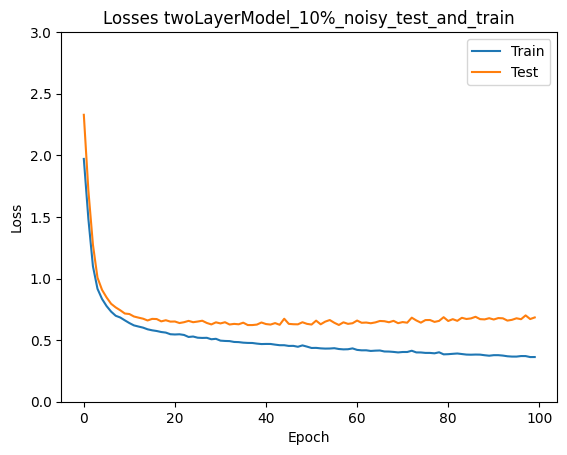

In [6]:
import time
from torchvision import transforms, datasets
import torch
from torch.utils.data import Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import random
from sklearn.metrics import precision_score, accuracy_score, f1_score

default_batch_size = 500
default_batch_size_10 = 128
default_batch_size_1 = 64

big_batch_size = 512

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

#how to get train and test data
train_data = datasets.FashionMNIST('path', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('path', download=True, train=False, transform=transform)


train_indices = list(range(len(train_data)))
random.shuffle(train_indices)
train_indices_10_percent = train_indices[:len(train_indices)//10]
train_indices_1_percent = train_indices[:len(train_indices)//100]

test_indices = list(range(len(test_data)))
random.shuffle(test_indices)
test_indices_10_percent = test_indices[:len(test_indices)//10]
test_indices_1_percent = test_indices[:len(test_indices)//100]

train_data_10_percent = Subset(train_data, train_indices_10_percent)
test_data_10_percent = Subset(test_data, test_indices_10_percent)

train_data_1_percent = Subset(train_data, train_indices_1_percent)
test_data_1_percent = Subset(test_data, test_indices_1_percent)

print('100%: ',len(train_data))
print('100%: ',len(test_data))
print('10%: ',len(train_data_10_percent))
print('10%: ',len(test_data_10_percent))
print('1%: ',len(train_data_1_percent))
print('1%: ',len(test_data_1_percent))
# print out rest of configuration
print('Default batch size: ',default_batch_size)
print('Big batch size: ',big_batch_size)

#Define a dataloader to load data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=default_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=default_batch_size, shuffle=True)

train_loader_10 = torch.utils.data.DataLoader(train_data_10_percent, batch_size=default_batch_size_10, shuffle=True)
test_loader_10 = torch.utils.data.DataLoader(test_data_10_percent, batch_size=default_batch_size_10, shuffle=True)

train_loader_1 = torch.utils.data.DataLoader(train_data_1_percent, batch_size=default_batch_size_1, shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_data_1_percent, batch_size=default_batch_size_1, shuffle=True)

train_loader_big_batch = torch.utils.data.DataLoader(train_data_10_percent, batch_size=big_batch_size, shuffle=True)
test_loader_big_batch = torch.utils.data.DataLoader(test_data_10_percent, batch_size=big_batch_size, shuffle=True)

#add gausian blur to 10% of train data
train_data_10_percent_noisy = []
for image, label in train_data_10_percent:
    image = transforms.ToPILImage()(image)
    image = transforms.GaussianBlur(kernel_size=5)(image)
    image = transforms.ToTensor()(image)
    train_data_10_percent_noisy.append((image, label))

test_data_10_percent_noisy = []
for image, label in test_data_10_percent:
    image = transforms.ToPILImage()(image)
    image = transforms.GaussianBlur(kernel_size=5)(image)
    image = transforms.ToTensor()(image)
    test_data_10_percent_noisy.append((image, label))


train_data_10_percent_noisy_loader = torch.utils.data.DataLoader(train_data_10_percent_noisy, batch_size=default_batch_size_10, shuffle=True)
test_data_10_percent_noisy_loader = torch.utils.data.DataLoader(test_data_10_percent_noisy, batch_size=default_batch_size_10, shuffle=True)

print('10%:' ,len(train_loader_10))
print('10%:' ,len(test_loader_10))


print('10% noisy: ',len(train_data_10_percent_noisy_loader))
print('10% noisy: ',len(test_data_10_percent_noisy_loader))

def train(model, criterion, data_loader, test_loader, epochs):
    #reset model
    model.apply(init_normal)
    optimizer = optim.Adam(model.parameters())
    torch.manual_seed(seed)

    start_timestamp = time.time()
    training_loss = []
    test_loss_list = []
    for epoch in range(epochs):
        running_loss = 0
        test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.shape[0], -1)
                logits = model(images)
                loss_test = criterion(logits, labels)
                test_loss += loss_test.item()

        for images, labels in data_loader:
            images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_loss = running_loss/len(data_loader)
        test_loss = test_loss/len(test_loader)
        training_loss.append(running_loss) 
        test_loss_list.append(test_loss)

        if (epoch) % 10 == 0:
            print(f"Epoch {epoch}/{epochs} - Train Loss: {running_loss:.4f}, Test Loss: {test_loss:.4f}")

    print(f"\nTraining Time (in seconds) = {(time.time()-start_timestamp):.2f}")
    return training_loss, test_loss_list

def plot_loss(losses, title):
    train, test = losses
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train' ,'Test'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.show()



# Define the network architecture
oneLayerModel = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 10),
                    nn.LogSoftmax(dim = 1))

oneLayerModel_big_batch = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 10),
                    nn.LogSoftmax(dim = 1))

oneLayerModel_less_neurons = nn.Sequential(
                      nn.Linear(784, 8),
                      nn.LeakyReLU(),
                      nn.Linear(8, 10),
                      nn.LogSoftmax(dim = 1))


#two layer model
twoLayerModel = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 8),
                    nn.LeakyReLU(),
                    nn.Linear(8, 10),
                    nn.LogSoftmax(dim = 1))

twoLayerModel_big_batch = nn.Sequential(
                    nn.Linear(784, 16),
                    nn.LeakyReLU(),
                    nn.Linear(16, 8),
                    nn.LeakyReLU(),
                    nn.Linear(8, 10),
                    nn.LogSoftmax(dim = 1))

twoLayerModel_less_neurons = nn.Sequential(
                        nn.Linear(784, 8),
                        nn.LeakyReLU(),
                        nn.Linear(8, 4),
                        nn.LeakyReLU(),
                        nn.Linear(4, 10),
                        nn.LogSoftmax(dim = 1))


def init_normal(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(seed)
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)

# Initialize the weights
oneLayerModel.apply(init_normal)
oneLayerModel_less_neurons.apply(init_normal)
oneLayerModel_big_batch.apply(init_normal)
twoLayerModel.apply(init_normal)
twoLayerModel_big_batch.apply(init_normal)
twoLayerModel_less_neurons.apply(init_normal)

# Define the loss
criterion = nn.NLLLoss();


epochs = 100

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')


# print('oneLayerModel 100%')
# oneLayerModel_losses = train(
#     oneLayerModel, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(oneLayerModel, test_loader)
# plot_loss(oneLayerModel_losses, 'Losses oneLayerModel 100%')

# print('oneLayerModel_less_neurons 100%')
# oneLayerModel_less_neurons_losses = train(
#     oneLayerModel_less_neurons, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(oneLayerModel_less_neurons, test_loader)
# plot_loss(oneLayerModel_less_neurons_losses, 'Losses oneLayerModel_less_neurons 100%')

# print('twoLayerModel 100%')
# twoLayerModel_losses = train(
#     twoLayerModel,
#     criterion,
#     train_loader,
#     test_loader,
#     epochs=10)
# evaluate_model(twoLayerModel, test_loader)
# plot_loss(twoLayerModel_losses, 'Losses twoLayerModel 100%')

# print('twoLayerModel_less_neurons 100%')
# twoLayerModel_less_neurons_losses = train(
#     twoLayerModel_less_neurons, 
#     criterion, 
#     train_loader, 
#     test_loader, 
#     epochs=10)
# evaluate_model(twoLayerModel_less_neurons, test_loader)
# plot_loss(twoLayerModel_less_neurons_losses, 'Losses twoLayerModel_less_neurons 100%')

# #-----------------10%-----------------

# print('oneLayerModel 10%')
# oneLayerModel_losses_10 = train(
#     oneLayerModel,
#     criterion,
#     train_loader_10,
#     test_loader_10,
#     epochs=epochs)
# evaluate_model(oneLayerModel, test_loader_10)
# plot_loss(oneLayerModel_losses_10, 'Losses oneLayerModel 10%')

# print('oneLayerModel_big_batch 10%')
# oneLayerModel_losses_big_batch = train(
#     oneLayerModel_big_batch, 
#     criterion, 
#     train_loader_big_batch, 
#     test_loader_big_batch, 
#     epochs=epochs)
# evaluate_model(oneLayerModel_big_batch, test_loader_big_batch)
# plot_loss(oneLayerModel_losses_big_batch, 'Losses oneLayerModel_big_batch 10%')

# print('oneLayerModel_less_neurons 10%')
# oneLayerModel_less_neurons_losses = train(
#     oneLayerModel_less_neurons,
#     criterion,
#     train_loader_10,
#     test_loader_10,
#     epochs=epochs)
# evaluate_model(oneLayerModel_less_neurons, test_loader_10)
# plot_loss(oneLayerModel_less_neurons_losses, 'Losses oneLayerModel_less_neurons 10%')

# print('twoLayerModel 10%')
# twoLayerModel_losses = train(
#     twoLayerModel, 
#     criterion, 
#     train_loader_10, 
#     test_loader_10, 
#     epochs=epochs)
# evaluate_model(twoLayerModel, test_loader_10)
# plot_loss(twoLayerModel_losses, 'Losses twoLayerModel 10%')

# print('twoLayerModel_big_batch 10%')
# twoLayerModel_losses_big_batch = train(
#     twoLayerModel_big_batch, 
#     criterion, 
#     train_loader_big_batch, 
#     test_loader_big_batch, 
#     epochs=epochs)
# evaluate_model(twoLayerModel_big_batch, test_loader_big_batch)

# plot_loss(twoLayerModel_losses_big_batch, 'Losses twoLayerModel_big_batch 10%')


# print('twoLayerModel_less_neurons 10%')
# twoLayerModel_less_neurons_losses = train(
#     twoLayerModel_less_neurons, 
#     criterion, 
#     train_loader_10, 
#     test_loader_10, 
#     epochs=epochs)
# evaluate_model(twoLayerModel_less_neurons, test_loader_10)

# plot_loss(twoLayerModel_less_neurons_losses, 'Losses twoLayerModel_less_neurons 10%')

# #-----------------1%-----------------

# print('oneLayerModel 1%')
# oneLayerModel_losses_1 = train(
#     oneLayerModel, 
#     criterion, 
#     train_loader_1, 
#     test_loader_1, 
#     epochs=epochs)
# evaluate_model(oneLayerModel, test_loader_1)
# plot_loss(oneLayerModel_losses_1, 'Losses oneLayerModel_1%')

# print('twoLayerModel 1%')
# #train model
# twoLayerModel_losses_1 = train(
#     twoLayerModel, 
#     criterion, 
#     train_loader_1, 
#     test_loader_1, 
#     epochs=epochs)

# evaluate_model(twoLayerModel, test_loader_1)
# plot_loss(twoLayerModel_losses_1, 'Losses twoLayerModel_1%')


#-----------------10% noisy-----------------



print('oneLayerModel_10%_noisy_test')
oneLayerModel_losses_10_noisy = train(
    oneLayerModel, 
    criterion, 
    train_loader_10, 
    test_data_10_percent_noisy_loader, 
    epochs=epochs)
evaluate_model(oneLayerModel, test_data_10_percent_noisy_loader)
plot_loss(oneLayerModel_losses_10_noisy, 'Losses oneLayerModel_10%_noisy_test')



print('oneLayerModel_10%_noisy_test_and_train')
oneLayerModel_losses_10_noisy = train(
    oneLayerModel, 
    criterion, 
    train_data_10_percent_noisy_loader, 
    test_data_10_percent_noisy_loader, 
    epochs=epochs)

evaluate_model(oneLayerModel, test_data_10_percent_noisy_loader)
plot_loss(oneLayerModel_losses_10_noisy, 'Losses oneLayerModel_10%_noisy_test_and_train')

print('twoLayerModel_10%_noisy_test')
twoLayerModel_losses_10_noisy = train(
    twoLayerModel, 
    criterion, 
    train_loader_10, 
    test_data_10_percent_noisy_loader, 
    epochs=epochs)
evaluate_model(twoLayerModel, test_data_10_percent_noisy_loader)
plot_loss(twoLayerModel_losses_10_noisy, 'Losses twoLayerModel_10%_noisy_test')

print('twoLayerModel_10%_noisy_test_and_train')
twoLayerModel_losses_10_noisy = train(
    twoLayerModel, 
    criterion, 
    train_data_10_percent_noisy_loader, 
    test_data_10_percent_noisy_loader, 
    epochs=epochs)
evaluate_model(twoLayerModel, test_data_10_percent_noisy_loader)
plot_loss(twoLayerModel_losses_10_noisy, 'Losses twoLayerModel_10%_noisy_test_and_train')






